In [2]:
# libs --------------------------------------------------------------------
require(SummarizedExperiment)
require(data.table)
require(tidyverse)
require(ggplot2)
require(scales)
require(ggpubr)
require(ComplexHeatmap)
require(pheatmap)
require(RColorBrewer)
require(parallelDist)
require(matlab)
require(cluster)
require(rlist)
require(chromVAR)
require(ggdendro)
require(extrafont)  # fonts 
# https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249, 249, 212, maxColorValue = 255), rgb(60, 
    181, 195, maxColorValue = 255), rgb(30, 35, 86, maxColorValue = 255)), space = "Lab")



theme_pubr<- function (base_size = 11, base_family = "Arial") 
{
    theme_foundation() + theme(line = element_line(colour = "black", 
        lineend = "round", linetype = "solid"), rect = element_rect(fill = "white", 
        colour = "black", linetype = "solid"), text = element_text(colour = "black", 
        face = "plain", family = base_family, size = base_size, 
        vjust = 0.5, hjust = 0.5, lineheight = 0.5), panel.background = element_blank(), 
        plot.background = element_blank(), panel.border = element_rect(colour = "black", 
            fill = NA), panel.grid = element_blank(), strip.background = element_rect(colour = NA), 
        legend.key = element_rect(colour = NA), title = element_text(size = rel(1)), 
        plot.title = element_text(size = rel(1.2), face = "bold"), 
        strip.text = element_text(), axis.ticks.length = unit(1, 
    "mm"))
}


# colors ------------------------------------------------------------------
cols.subcluster <- c('red4','red3','red1','steelblue4','steelblue1','green4','green1',
                     'purple4','purple1',brewer.pal(9,'Set1')[5:9])
cols.celltype <- c(acinar='grey',alpha_1="darkred",alpha_2="lightpink",beta_1="darkgreen",beta_2="lightgreen",
                   delta_1="orange",delta_2="gold",ductal="cyan",
                   gamma="purple",exocrine="black",endothelial_1="royalblue",endothelial_2="navy",immune="blue",
                   stellate="skyblue",glial="cyan")
cols.celltype["beta"] = rgb(t((col2rgb(cols.celltype["beta_1"]) + col2rgb(cols.celltype["beta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["alpha"] = rgb(t((col2rgb(cols.celltype["alpha_1"]) + col2rgb(cols.celltype["alpha_2"]))/2), 
    maxColorValue = 255)
cols.celltype["delta"] = rgb(t((col2rgb(cols.celltype["delta_1"]) + col2rgb(cols.celltype["delta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["endothelial"] = rgb(t((col2rgb(cols.celltype["endothelial_1"]) + col2rgb(cols.celltype["endothelial_2"]))/2), 
    maxColorValue = 255)



##  1. load data

In [3]:
dat.pro_ps<- fread("../dat/1910_v2/abd.promoter.long_matrix_w_transcripts_ps.txt")
head(dat.pro_ps,1)
dim(dat.pro_ps)

prom_peak,cell,ps,celltype
10:100027284-100028604,Islet1fresh_AGACACCTAAGAGGCAGCGTAAGAAGGCG,11.8747,alpha


[1] 18019112        4

## 2. function to get openning  along ps bins for pomoter

In [28]:
dat.ps.bins%>%arrange(ps_bin_idx)%>%head()

ps_bin_idx,ps_bin,celltype,N
1,"[0,0.185)",beta,104
1,"[0,0.209)",alpha,172
1,"[0,0.749)",delta,51
2,"[0.185,0.37)",beta,14
2,"[0.209,0.417)",alpha,48
2,"[0.749,1.5)",delta,19


In [4]:
dat.ps.bins <- fread("../dat/1910_v2/ps.bin.dat.sum.csv") %>% select(ps_bin_idx, 
    ps_bin, celltype, N)

alpha,beta,delta
"0.00000, 20.85655","0.00000, 18.49255","0.00000, 14.97356"


In [23]:
ct <- "alpha"
prom = "2:163007699-163009094"
dat.pro_ps.sub <- dat.pro_ps %>% filter(prom_peak == prom, celltype == ct) %>% mutate(ps_bin = cut(ps, 
    breaks = ps.bks[[ct]], include.lowest = T, right = F))
## count
setDT(dat.pro_ps.sub)
dat.pro_ps.sub.cnt <- dat.pro_ps.sub[, .(open_cells = .N), by = .(ps_bin, celltype)] %>% 
    left_join(dat.ps.bins) %>% select(ps_bin_idx, ps_bin, open_cells, N, celltype) %>% 
    mutate(percent.open = open_cells/N * 100)

Joining, by = c("ps_bin", "celltype")
Warning message:
“Column `ps_bin` joining factor and character vector, coercing into character vector”

alpha,beta,delta
"0.00000, 20.85655","0.00000, 18.49255","0.00000, 14.97356"


Joining, by = c("ps_bin", "celltype")


   user  system elapsed 
  0.540   0.095   0.635 

Joining, by = c("ps_bin", "celltype")


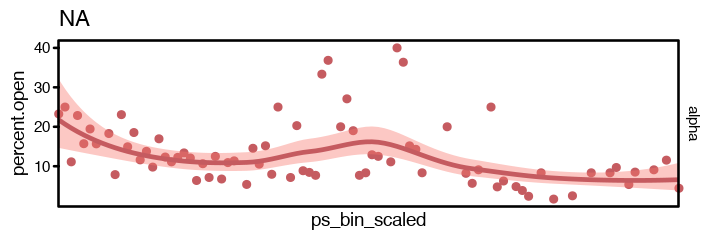

   user  system elapsed 
  0.465   0.005   0.472 

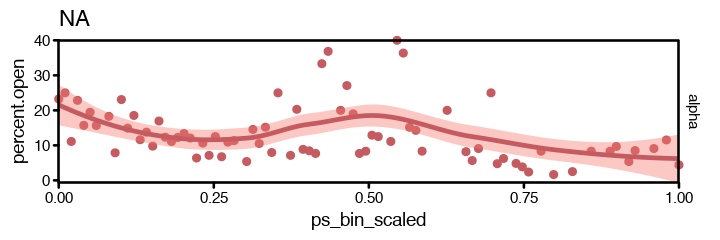

In [30]:
## load all required data
ps.range <- lapply(c("alpha", "beta", "delta"), function(ct) dat.pro_ps %>% filter(celltype == 
    ct) %>% pull(ps) %>% range)
names(ps.range) <- c("alpha", "beta", "delta")
ps.range %>% t
N.bin <- 101
N.bin.d <- 21
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1], ps.range$alpha[2] + 1e-05, length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1], ps.range$beta[2] + 1e-05, length.out = N.bin)
ps.bks$delta <- seq(ps.range$delta[1], ps.range$delta[2] + 1e-05, length.out = N.bin.d)



## functions
fun.getOpenCellsPerBinOneCelltype <- function(prom = "10:100027284-100028604", ct = "alpha") {
    
    dat.pro_ps.sub <- dat.pro_ps %>% filter(prom_peak == prom, celltype == ct) %>% 
        mutate(ps_bin = cut(ps, breaks = ps.bks[[ct]], include.lowest = T, right = F))
    ## count
    setDT(dat.pro_ps.sub)
    dat.pro_ps.sub.cnt <- dat.pro_ps.sub[, .(open_cells = .N), by = .(ps_bin, celltype)] %>% 
        left_join(dat.ps.bins) %>% select(ps_bin_idx, ps_bin, open_cells, N, celltype) %>% 
        mutate(percent.open = open_cells/N * 100)
    dat.pro_ps.sub.cnt
}
fun.addSmoothFracPerBinOneCelltype <- function(promoter = "10:100027284-100028604", 
    doPlot = F, npoints = 50, title = NA, ct_ = "alpha") {
    scale_range <- function(x) (x - min(x))/(max(x) - min(x))
    tmp <- fun.getOpenCellsPerBinOneCelltype(promoter, ct_)
    setDT(tmp)
    tmp[, `:=`(ps_bin_scaled, scale_range(ps_bin_idx)), by = celltype]
    
    ## avoid negative
    ## https://stackoverflow.com/questions/2777053/in-ggplot-restrict-y-to-be-0-in-loess
    require(scales)
    # create exp(x)-1 transformation, the inverse of log(1+p)
    expm1_trans <- function() trans_new("expm1", "expm1", "log1p")
    
    
    p <- ggplot(tmp, aes(ps_bin_scaled, percent.open, color = celltype, fill = celltype)) + 
        geom_point() + scale_color_manual(values = cols.celltype) + stat_smooth(aes(color = celltype, 
        outfit = fit.y <<- ..y..), n = npoints, method = "loess") + theme_pubr() + 
        facet_grid(celltype ~ ., scales = "free_y") + theme(legend.position = "none", 
        strip.background = element_blank()) + ggtitle(title) + scale_y_continuous(trans = log1p_trans()) + 
        coord_trans(y = expm1_trans(), clip = "off") + scale_x_discrete(expand = c(0, 
        0))  #+ coord_cartesian(expand = F, clip = 'off')
    
    if ((p$data %>% nrow()) > 2) {
        if (doPlot) 
            print(p)
        
        return(list(plt = p, smoothed.data = data.frame(ps = 1:npoints, smoothed.percent.open = expm1(fit.y), 
            celltype = rep(ct_, each = npoints)) %>% mutate(prom_peak = promoter)))
        
    } else (return(NULL))
}

fun.addSmoothFracPerBinOneCelltypeNoTrans <- function(promoter = "10:100027284-100028604", 
    doPlot = F, npoints = 50, title = NA, ct_ = "alpha") {
    scale_range <- function(x) (x - min(x))/(max(x) - min(x))
    tmp <- fun.getOpenCellsPerBinOneCelltype(promoter, ct_)
    setDT(tmp)
    tmp[, `:=`(ps_bin_scaled, scale_range(ps_bin_idx)), by = celltype]
    
    
    
    p <- ggplot(tmp, aes(ps_bin_scaled, percent.open, color = celltype, fill = celltype)) + 
        geom_point() + scale_color_manual(values = cols.celltype) + stat_smooth(aes(color = celltype, 
        outfit = fit.y <<- ..y..), n = npoints, method = "loess") + theme_pubr() + 
        facet_grid(celltype ~ ., scales = "free_y") + theme(legend.position = "none", 
        strip.background = element_blank()) + ggtitle(title) + coord_cartesian(expand = F, 
        clip = "off")
    
    if ((p$data %>% nrow()) > 2) {
        if (doPlot) 
            print(p)
        
        return(list(plt = p, smoothed.data = data.frame(ps = 1:npoints, smoothed.percent.open = expm1(fit.y), 
            celltype = rep(ct_, each = npoints)) %>% mutate(prom_peak = promoter)))
        
    } else (return(NULL))
}

options(repr.plot.width = 6, repr.plot.height = 2)



system.time(suppressWarnings(res <- fun.addSmoothFracPerBinOneCelltype(doPlot = T, 
    npoints = 100, promoter = "2:163007699-163009094")))
# res$smoothed.data$smoothed.percent.open %>% range res$smoothed.data %>% head(1)

system.time(suppressWarnings(res <- fun.addSmoothFracPerBinOneCelltypeNoTrans(doPlot = T, 
    npoints = 100, promoter = "2:163007699-163009094")))

## 3. get smoothed data for DA promoters

In [255]:
da.tss.peaks <- fread("../figures/Fig2/subfigs/fig_2.prom.sub_vs_sub.fisher.uniq_gene.csv") %>% 
    mutate(FDR.th = ifelse(celltype == "delta", 0.1, 0.01)) %>% filter(FDR < FDR.th) %>% 
    select(prom_peak, gene, celltype)
da.tss.peaks%>%pull(celltype)%>%table
dat.pro_ps <- dat.pro_ps %>% right_join(da.tss.peaks)
da.tss.peaks%>%head(1)
da.tss.peaks%>%nrow

.
alpha  beta delta 
 4638  1133  2284 

Joining, by = c("prom_peak", "celltype")


prom_peak,gene,celltype
1:100503350-100504585,HIAT1,alpha


[1] 8055

In [181]:
tmp.pdf <- paste0(tempfile(), ".pdf")
pdf(file = tmp.pdf, onefile = T)
system.time(res <- do.call(rbind, mclapply(mc.cores = 6, 1:nrow(da.tss.peaks), function(i) {
    tmp <- fun.addSmoothFracPerBinOneCelltype(npoints = 100, ct_ = da.tss.peaks$celltype[i], 
        doPlot = T, promoter = da.tss.peaks$prom_peak[i])$smoothed.data
    if (length(tmp) > 0) 
        return(tmp %>% mutate(gene = da.tss.peaks$gene[i]))
    return(NULL)
})))
dev.off()
res %>% head(1)
fwrite(res, "../dat/1910_v2/DA_prom_long_100bins_ps.csv")

    user   system  elapsed 
2807.406  152.690  531.759 

pdf 
  2

ps,smoothed.percent.open,celltype,prom_peak,gene
0,24.73457,alpha,1:100503350-100504585,HIAT1


## 4 heatmap & clustering

In [31]:
res<- fread( "../dat/1910_v2/DA_prom_long_100bins_ps.csv")

In [32]:
## convert ps to bins
res.2 <- res
setDT(res.2)
res.2 <- res.2[, `:=`(ps_idx, as.numeric(factor(ps))), by = celltype]
dat.pro_ps.wd <- res.2 %>% select(-ps) %>% group_by(celltype) %>% spread(key = ps_idx, 
    value = smoothed.percent.open)
dat.pro_ps.wd %>% head(2)
dat.pro_ps.wd %>% tail(2)
table(dat.pro_ps.wd$celltype)
# fwrite(dat.pro_ps.wd, '../dat/1910_v2/DA_prom_wd_100bins_ps.csv')

celltype,prom_peak,gene,1,2,3,4,5,6,7,⋯,91,92,93,94,95,96,97,98,99,100
alpha,1:100503350-100504585,HIAT1,24.73457,23.13069,21.67696,20.35785,19.15964,18.07025,17.07894,⋯,21.227851,20.966708,20.689589,20.396946,20.089276,19.767118,19.431054,19.081703,18.719724,18.345811
alpha,1:100817645-100818537,CDC14A,16.81362,16.00408,15.25797,14.57011,13.93580,13.35081,12.81130,⋯,9.797414,9.780207,9.766321,9.755589,9.747845,9.742927,9.740676,9.740935,9.743548,9.748361


celltype,prom_peak,gene,1,2,3,4,5,6,7,⋯,91,92,93,94,95,96,97,98,99,100
delta,X:77040892-77042098,ATRX,4.214989,4.420346,4.627380,4.835066,5.042274,5.247765,5.450767,⋯,9.652938,9.810389,9.975356,10.14807,10.32878,10.51774,10.71523,10.92154,11.13697,11.36184
delta,X:80065057-80065774,BRWD3,4.885636,5.148554,5.414905,5.683959,5.954925,6.226949,6.499116,⋯,13.796952,13.914725,14.029531,14.14138,14.25028,14.35626,14.45933,14.55953,14.65688,14.75142



alpha  beta delta 
 4638  1133  2283 

### 4.2 cluster on one celltype

#### 4.2.1 alpha cells 

tr.keep
FALSE  TRUE 
 2992  1646 

pdf 
  2

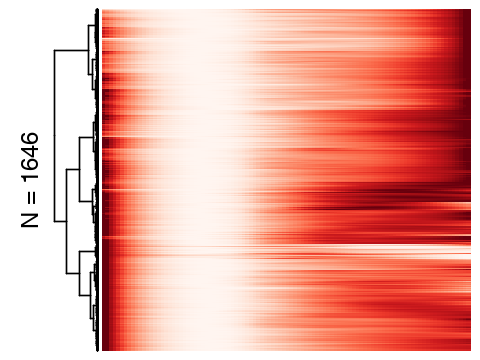

In [86]:
options(repr.plot.width = 4, repr.plot.height = 3)

dat.sub <- dat.pro_ps.wd %>% as.data.frame() %>% filter(celltype == "alpha") %>% 
    column_to_rownames("gene") %>% select(-celltype, -prom_peak)

tr.keep <- apply(dat.sub, 1, max) >= 25
table(tr.keep)
dat.sub.2 <- dat.sub[tr.keep, ]
# dat.sub.2.scale <- t(apply(dat.sub.2, 1, function(x) x/max(x)))

dat.sub.2.scale <- t(apply(dat.sub.2, 1, function(x) {
    rg <- quantile(x, c(0.01, 0.99)) %>% as.numeric
    x[x > rg[2]] <- rg[2]
    x[x < rg[1]] <- rg[1]
    (x - rg[1])/(rg[2] - rg[1])
    # x/rg[2]
}))


ht <- Heatmap(dat.sub.2.scale, name = "motif_activity", cluster_columns = F, row_title = paste("N =", 
    nrow(dat.sub.2.scale)), row_dend_reorder = F, clustering_method_rows = "ward.D", 
    clustering_distance_rows = "euclidean", show_heatmap_legend = F, show_row_dend = T, 
    show_row_names = F, show_column_names = F, col = colorRampPalette(colors = brewer.pal(n = 9, 
        name = "Reds"))(20))
draw(ht)

pdf("~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/alpha_ps_hclust.pdf", 
    width = 4, height = 3, family = "Arial")
draw(ht)
dev.off()
system("open ~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/alpha_ps_hclust.pdf")

dat.sub.2.scale <- dat.sub.2.scale[row_order(ht)[[1]], ]

2  clusters  0.2825923 
3  clusters  0.302795 
4  clusters  0.275674 
5  clusters  0.3029559 
6  clusters  0.2602389 
7  clusters  0.2421918 
8  clusters  0.2441291 
9  clusters  0.243501 
10  clusters  0.2303204 



  1   2   3   4   5 
345 505 416 313  67 

2  clusters  0.313615 
3  clusters  0.2948487 
4  clusters  0.281204 
5  clusters  0.2584084 
6  clusters  0.2506109 
7  clusters  0.2536393 
8  clusters  0.2296657 
9  clusters  0.2513165 
10  clusters  0.243801 

  1   2 
135 210 


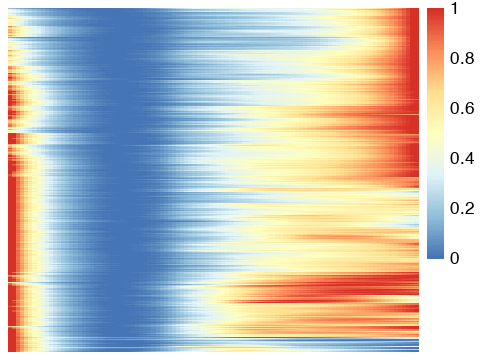

2  clusters  0.2342267 
3  clusters  0.2432485 
4  clusters  0.2028748 
5  clusters  0.2089039 
6  clusters  0.2078635 
7  clusters  0.2123621 
8  clusters  0.2031495 
9  clusters  0.2098872 
10  clusters  0.1997497 

  1   2   3 
156 172 177 


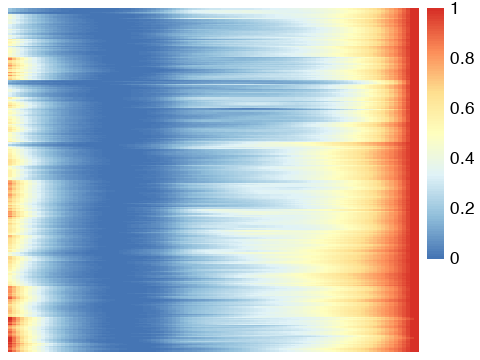

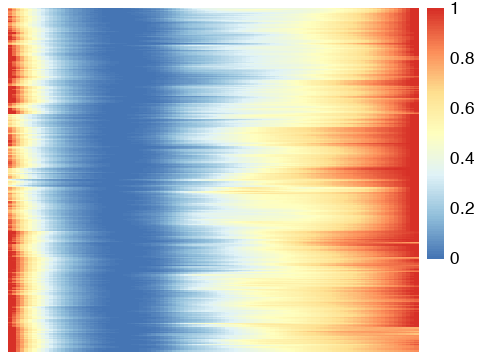

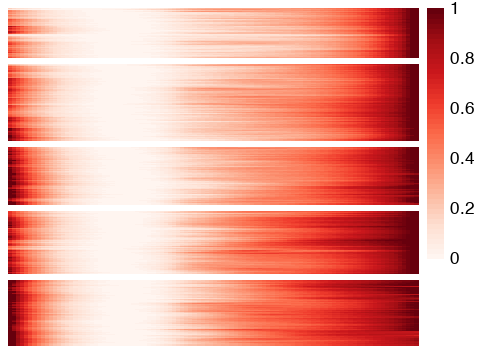

In [87]:
pk.scale <- pamk(dat.sub.2.scale, critout = T)
table(pk.scale$pamobject$clustering)

pheatmap(dat.sub.2.scale[order(pk.scale$pamobject$clustering), ], scale = "none", 
    cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F)

pk.scale.2 <- list()
dat.sub.2.scale.1 <- list()

for (i in 1:2) {
    # cat(paste0('For Cluster ',i,'\n'))
    dat.sub.2.scale.1[[i]] <- dat.sub.2.scale[pk.scale$pamobject$clustering == i, 
        ]
    pk.scale.2[[i]] <- pamk(dat.sub.2.scale.1[[i]], critout = T)
    print(table(pk.scale.2[[i]]$pamobject$clustering))
    pheatmap(dat.sub.2.scale.1[[i]][order(pk.scale.2[[i]]$pamobject$clustering), 
        ], border_color = NA, scale = "none", cluster_rows = F, cluster_cols = F, 
        show_rownames = F, show_colnames = F)
}

# 
a = (pk.scale.2[[1]]$pamobject$clustering)
b1 = a
names(b1) = names(a)

a = (pk.scale.2[[2]]$pamobject$clustering)
b2 = a + length(unique(b1))
names(b2) = names(a)


final.ord = c(b1, b2)


pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)], ], gaps_row = as.numeric(cumsum(table(final.ord))), 
    scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
    color = colorRampPalette(colors = brewer.pal(n = 9, name = "Reds"))(50), )

pdf 
  2

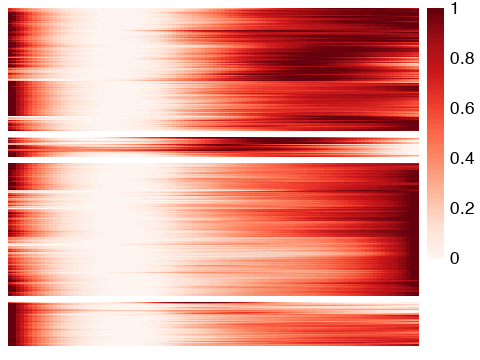

In [70]:
# 
a = (pk.scale.2[[1]]$pamobject$clustering)
b1 = a
names(b1) = names(a)

a = (pk.scale.2[[2]]$pamobject$clustering)
b2 = a + 2
names(b2) = names(a)


final.ord = c(b1, b2)


options(repr.plot.width = 4, repr.plot.height = 3)
p <- pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)], ], gaps_row = as.numeric(cumsum(table(final.ord))), 
    scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
    color = colorRampPalette(colors = brewer.pal(n = 9, name = "Reds"))(50), )

pdf("~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/alpha_ps_pamk.pdf", 
    width = 4, height = 3, family = "Arial")
print(p)
dev.off()
system("open ~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/alpha_ps_pamk.pdf")

#### 4.2.2 Beta cells 

In [33]:
pd.anno.celltype.2 <- fread("../figures/Fig2/subfigs/fig2e.PS_anno_celltype.csv")

cols <- list(alpha = c(cols.celltype["alpha_1"], cols.celltype["alpha_2"]), beta = c(cols.celltype["beta_1"], 
    cols.celltype["beta_2"]), delta = c(cols.celltype["delta_1"], cols.celltype["delta_2"]))

In [45]:
smoothed.prom.pt.scaled.list <- lapply(c("alpha", "beta", "delta"), function(ct) {
    dat.sub <- dat.pro_ps.wd %>% as.data.frame() %>% filter(celltype == ct) %>% column_to_rownames("gene") %>% 
        select(-celltype, -prom_peak)
    max.fun <- function(x, th = 5) sum(x > th)
    tr.keep <- apply(dat.sub, 1, max.fun) >= 20
    
    table(tr.keep)%>%print
    dat.sub.2.scale <- dat.sub.2 <- dat.sub[tr.keep, ]
    # dat.sub.2.scale <- t(apply(dat.sub.2, 1, function(x) x/max(x)))
    
    # dat.sub.2.scale <- t(apply(dat.sub.2, 1, function(x) { rg <- quantile(x, c(0,
    # 1)) %>% as.numeric x[x > rg[2]] <- rg[2] x[x < rg[1]] <- rg[1] (x -
    # rg[1])/(rg[2] - rg[1]) x/rg[2] }))
    
    dat.sub.2.scale
})
names(smoothed.prom.pt.scaled.list) <- c("alpha", "beta", "delta")

tr.keep
FALSE  TRUE 
  204  4434 
tr.keep
FALSE  TRUE 
  324   809 
tr.keep
FALSE  TRUE 
   30  2253 


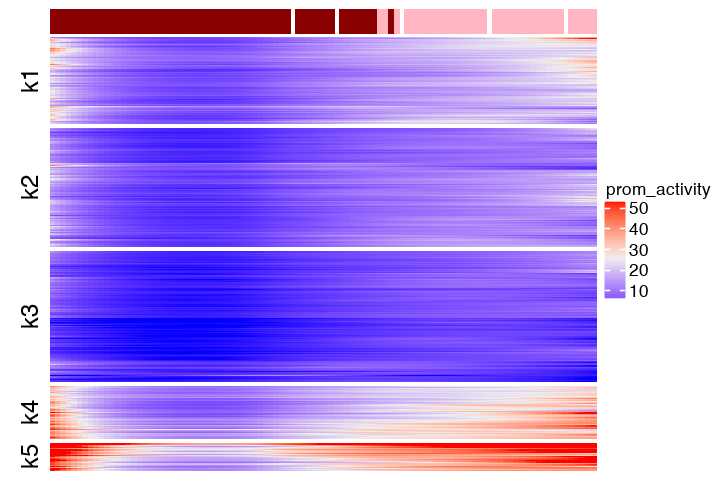

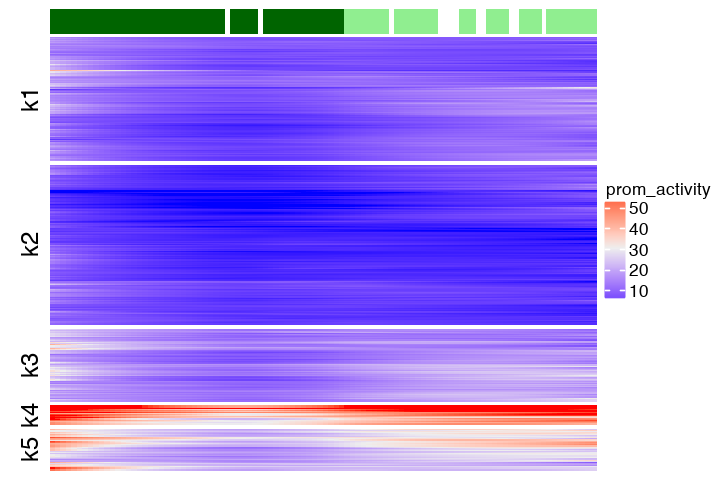

[[1]]
[1] 2

[[2]]
[1] 2

[[3]]
[1] 2

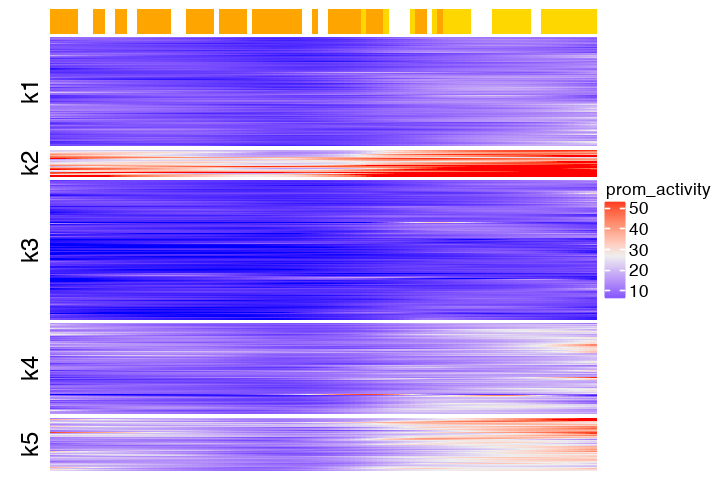

In [47]:
red.cols <- brewer.pal(n = 9, name = "Reds")
require(circlize)
lapply(c("alpha", "beta", "delta"), function(ct) {
    ncols <- lapply(smoothed.prom.pt.scaled.list, ncol)
    
    difs <- setdiff(1:ncols[[ct]], pd.anno.celltype.2 %>% filter(celltype == ct) %>% 
        pull(ps_bin_idx))
    
    
    pd.anno <- pd.anno.celltype.2 %>% filter(celltype == ct) %>% mutate(subtype = as.numeric(factor(subtype))) %>% 
        rbind(data.frame(celltype = ct, ps_bin_idx = difs, subtype = 0)) %>% spread(ps_bin_idx, 
        subtype, fill = 0) %>% column_to_rownames("celltype")
    
    options(repr.plot.width = 6, repr.plot.height = 4)
    column_ha <- HeatmapAnnotation(celltype = pd.anno %>% as.character, col = list(celltype = c(`1` = cols[[ct]][[1]], 
        `2` = cols[[ct]][[2]], `0` = NA)), show_legend = F)
    nr <- smoothed.prom.pt.scaled.list[[ct]] %>% nrow
    
    pa = cluster::pam(smoothed.prom.pt.scaled.list[[ct]], k = 5)
    
    
    ht <- Heatmap(smoothed.prom.pt.scaled.list[[ct]], split = paste0("k", pa$clustering), 
        name = "prom_activity", cluster_columns = F, row_title = paste("N =", nr), 
        row_dend_reorder = F, clustering_method_rows = "ward.D", clustering_distance_rows = "euclidean", 
        show_heatmap_legend = T, show_row_dend = F, show_row_names = F, show_column_names = F, 
        top_annotation = column_ha)
    # col = colorRamp2(c(0, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1), c('white',
    # red.cols[c(1, 4:9)])))
    draw(ht)
    
    pdf(paste0("~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/", 
        ct, "_ps_hclust.pdf"), width = 4, height = 3, family = "Arial")
    draw(ht)
    dev.off()
    system(paste0("open ~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/", 
        ct, "_ps_hclust.pdf"))
})

2  clusters  0.5105721 
3  clusters  0.3783376 
4  clusters  0.3460116 
5  clusters  0.3601345 
6  clusters  0.2990768 
7  clusters  0.2564641 
8  clusters  0.2549122 
9  clusters  0.2612353 
10  clusters  0.2447943 



  1   2 
471 502 

2  clusters  0.2764106 
3  clusters  0.3033014 
4  clusters  0.246281 
5  clusters  0.2387691 
6  clusters  0.2332794 
7  clusters  0.2343068 
8  clusters  0.2411771 
9  clusters  0.2325022 
10  clusters  0.2255384 

  1   2   3 
158 102 211 


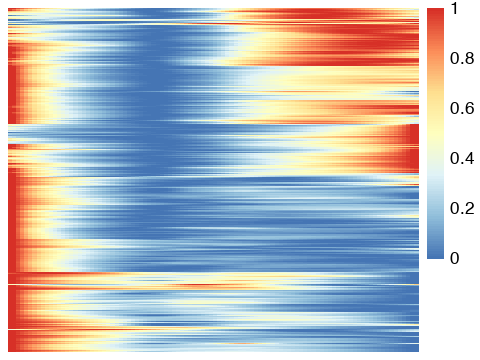

2  clusters  0.4223537 
3  clusters  0.2483623 
4  clusters  0.2123655 
5  clusters  0.2458565 
6  clusters  0.1579158 
7  clusters  0.156116 
8  clusters  0.1719282 
9  clusters  0.1777429 
10  clusters  0.1859453 

  1   2 
369 133 


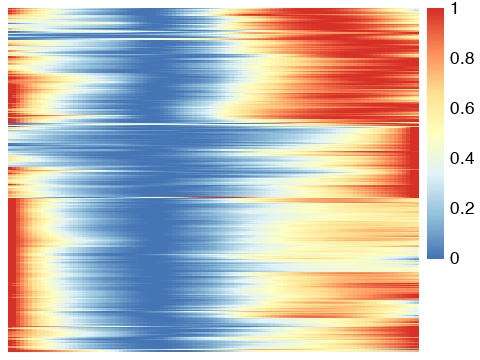

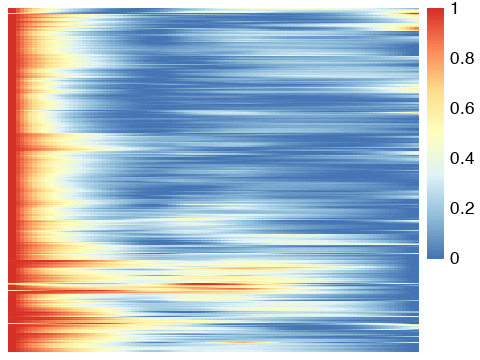

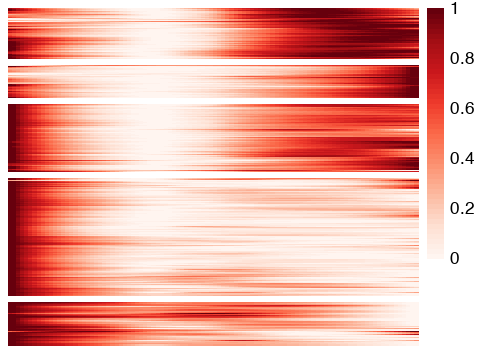

In [89]:
pk.scale <- pamk(dat.sub.2.scale, critout = T)
table(pk.scale$pamobject$clustering)

pheatmap(dat.sub.2.scale[order(pk.scale$pamobject$clustering), ], scale = "none", 
    cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F)

pk.scale.2 <- list()
dat.sub.2.scale.1 <- list()

for (i in 1:2) {
    # cat(paste0('For Cluster ',i,'\n'))
    dat.sub.2.scale.1[[i]] <- dat.sub.2.scale[pk.scale$pamobject$clustering == i, 
        ]
    pk.scale.2[[i]] <- pamk(dat.sub.2.scale.1[[i]], critout = T)
    print(table(pk.scale.2[[i]]$pamobject$clustering))
    pheatmap(dat.sub.2.scale.1[[i]][order(pk.scale.2[[i]]$pamobject$clustering), 
        ], border_color = NA, scale = "none", cluster_rows = F, cluster_cols = F, 
        show_rownames = F, show_colnames = F)
}

# 
a = (pk.scale.2[[1]]$pamobject$clustering)
b1 = a
names(b1) = names(a)

a = (pk.scale.2[[2]]$pamobject$clustering)
b2 = a + length(unique(b1))
names(b2) = names(a)


final.ord = c(b1, b2)


pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)], ], gaps_row = as.numeric(cumsum(table(final.ord))), 
    scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
    color = colorRampPalette(colors = brewer.pal(n = 9, name = "Reds"))(50), )


pdf 
  2

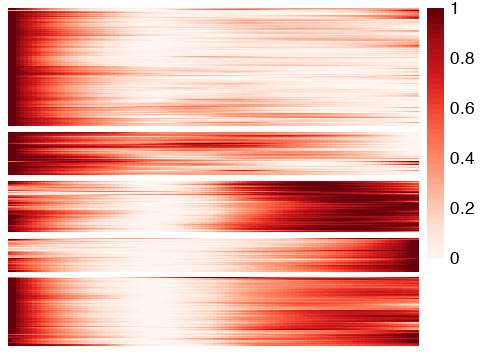

In [90]:
# 
a = (pk.scale.2[[1]]$pamobject$clustering)
b1 = a + 2
names(b1) = names(a)

a = (pk.scale.2[[2]]$pamobject$clustering)
b2 = a
names(b2) = names(a)


final.ord = c(b1, b2)


options(repr.plot.width = 4, repr.plot.height = 3)
p<- pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)], ], gaps_row = as.numeric(cumsum(table(final.ord))), 
    scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
    color = colorRampPalette(colors = brewer.pal(n = 9, name = "Reds"))(50), )

pdf("~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/beta_ps_pamk.pdf", 
    width = 4, height = 3, family = "Arial")
print(p)
dev.off()
system("open ~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/beta_ps_pamk.pdf")

#### 4.2.3 delta cells

tr.keep
FALSE  TRUE 
    4  2279 

pdf 
  2

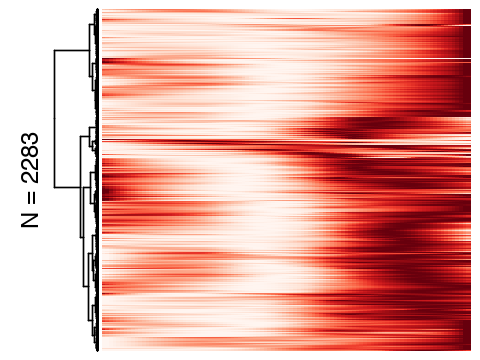

In [71]:
options(repr.plot.width = 4, repr.plot.height = 3)

dat.sub <- dat.pro_ps.wd %>% as.data.frame() %>% filter(celltype == "delta") %>% 
    column_to_rownames("gene") %>% select(-celltype, -prom_peak)

tr.keep <- apply(dat.sub, 1, max) >= 5
table(tr.keep)
dat.sub.2 <- dat.sub[tr.keep, ]
dat.sub.2.scale <- t(apply(dat.sub, 1, function(x) x/max(x)))

dat.sub.2.scale <- t(apply(dat.sub, 1, function(x) {
    rg <- quantile(x, c(0.01, 0.99)) %>% as.numeric
    x[x > rg[2]] <- rg[2]
    x[x < rg[1]] <- rg[1]
    (x - rg[1])/(rg[2] - rg[1])
    # x/rg[2]
}))


ht <- Heatmap(dat.sub.2.scale, name = "motif_activity", cluster_columns = F, row_title = paste("N =", 
    nrow(dat.sub.2.scale)), row_dend_reorder = F, clustering_method_rows = "ward.D", 
    clustering_distance_rows = "euclidean", show_heatmap_legend = F, show_row_dend = T, 
    show_row_names = F, show_column_names = F, col = colorRampPalette(colors = brewer.pal(n = 9, 
        name = "Reds"))(20))
draw(ht)

pdf("~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/delta_ps_hclust.pdf", 
    width = 4, height = 3, family = "Arial")
draw(ht)
dev.off()
system("open ~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/delta_ps_hclust.pdf")

dat.sub.2.scale <- dat.sub.2.scale[row_order(ht)[[1]], ]

2  clusters  0.2564433 
3  clusters  0.2008842 
4  clusters  0.1825074 
5  clusters  0.1602529 
6  clusters  0.1507956 
7  clusters  0.1570255 
8  clusters  0.1625385 
9  clusters  0.1693445 
10  clusters  0.1492892 



   1    2 
1029 1254 

2  clusters  0.1963051 
3  clusters  0.1820342 
4  clusters  0.1654351 
5  clusters  0.1572617 
6  clusters  0.1875012 
7  clusters  0.199479 
8  clusters  0.1667619 
9  clusters  0.1777261 
10  clusters  0.1671735 

  1   2   3   4   5   6   7 
254 150 152 192 207  33  41 


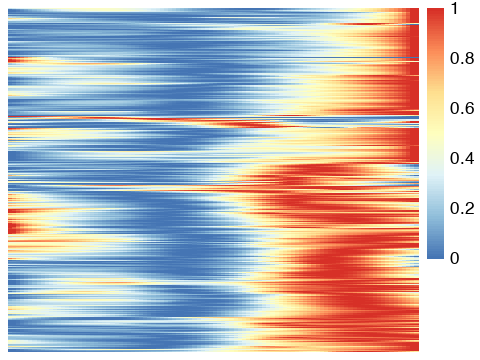

2  clusters  0.2086981 
3  clusters  0.1820979 
4  clusters  0.1775067 
5  clusters  0.1548135 
6  clusters  0.1690416 
7  clusters  0.1680175 
8  clusters  0.1493604 
9  clusters  0.1407814 
10  clusters  0.1445924 

  1   2 
696 558 


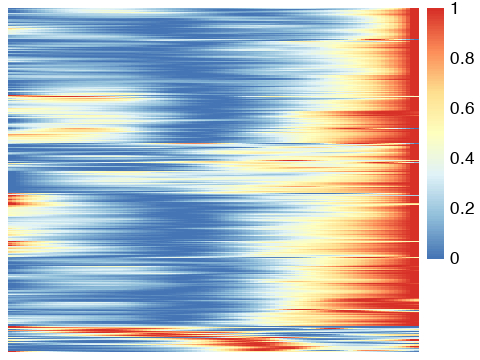

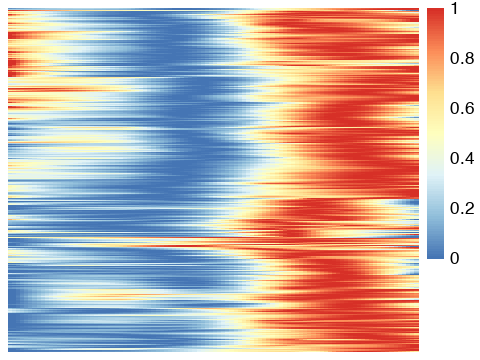

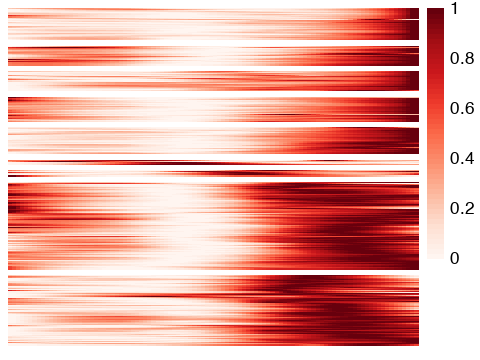

In [72]:
pk.scale <- pamk(dat.sub.2.scale, critout = T)
table(pk.scale$pamobject$clustering)

pheatmap(dat.sub.2.scale[order(pk.scale$pamobject$clustering), ], scale = "none", 
    cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F)

pk.scale.2 <- list()
dat.sub.2.scale.1 <- list()

for (i in 1:2) {
    # cat(paste0('For Cluster ',i,'\n'))
    dat.sub.2.scale.1[[i]] <- dat.sub.2.scale[pk.scale$pamobject$clustering == i, 
        ]
    pk.scale.2[[i]] <- pamk(dat.sub.2.scale.1[[i]], critout = T)
    print(table(pk.scale.2[[i]]$pamobject$clustering))
    pheatmap(dat.sub.2.scale.1[[i]][order(pk.scale.2[[i]]$pamobject$clustering), 
        ], border_color = NA, scale = "none", cluster_rows = F, cluster_cols = F, 
        show_rownames = F, show_colnames = F)
}

# 
a = (pk.scale.2[[1]]$pamobject$clustering)
b1 = a
names(b1) = names(a)

a = (pk.scale.2[[2]]$pamobject$clustering)
b2 = a + length(unique(b1))
names(b2) = names(a)


final.ord = c(b1, b2)


pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)], ], gaps_row = as.numeric(cumsum(table(final.ord))), 
    scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
    color = colorRampPalette(colors = brewer.pal(n = 9, name = "Reds"))(50), )

pdf 
  2

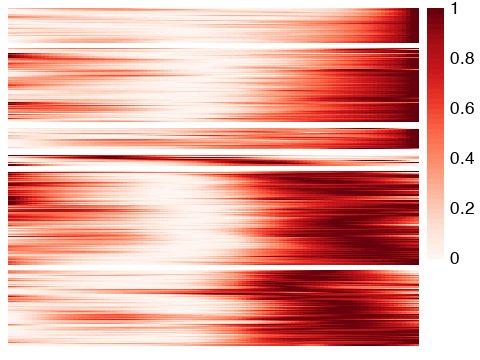

In [77]:
# 
a = (pk.scale.2[[1]]$pamobject$clustering)
b1 = ifelse(a == 7, 6, a)
names(b1) = names(a)
b1 = ifelse(b1 == 4, 2, ifelse(b1 > 4, b1 - 1, b1))
b1 = ifelse(b1 == 4, 2, ifelse(b1 > 4, b1 - 1, b1))

a = (pk.scale.2[[2]]$pamobject$clustering)
b2 = a + length(unique(b1))

names(b2) = names(a)


final.ord = c(b1, b2)


options(repr.plot.width = 4, repr.plot.height = 3)
p <- pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)], ], gaps_row = as.numeric(cumsum(table(final.ord))), 
    scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = F, show_colnames = F, 
    color = colorRampPalette(colors = brewer.pal(n = 9, name = "Reds"))(50), )

pdf("~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/delta_ps_pamk.pdf", 
    width = 4, height = 3, family = "Arial")
print(p)
dev.off()
system("open ~/Dropbox (UCSD_Epigenomics)/workReports/2019-12-06_islet_psclusters/delta_ps_pamk.pdf")

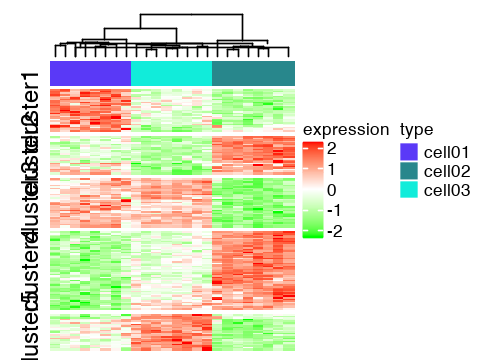

In [84]:
library(ComplexHeatmap)
library(circlize)

expr = readRDS(system.file(package = "ComplexHeatmap", "extdata", "gene_expression.rds"))
mat = as.matrix(expr[, grep("cell", colnames(expr))])
base_mean = rowMeans(mat)
mat_scaled = t(apply(mat, 1, scale))

type = gsub("s\\d+_", "", colnames(mat))
ha = HeatmapAnnotation(type = type, annotation_name_side = "left")

Heatmap(mat_scaled, name = "expression", km = 5, col = colorRamp2(c(-2, 0, 2), c("green", 
    "white", "red")), top_annotation = ha, show_column_names = FALSE, show_row_names = F, 
    row_title = NULL, show_row_dend = FALSE)

In [81]:
?Heatmap